# Prepare data and utility functions

In [1]:
import numpy as np 
import pandas as pd 
import os 
import time 
from tqdm import tqdm 
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold 
import math 
import random 
import matplotlib.pyplot as plt
from tensorflow.keras.models import *
from tensorflow.keras.layers import *  
from tensorflow.keras.callbacks import *


In [2]:
train_x = pd.read_csv('train_x_df.csv') 
train_y = pd.read_csv('train_y_df.csv') 
test_x = pd.read_csv('test_x_df.csv') 
submission = pd.read_csv('sample_submission.csv') 

In [3]:
def df2d_to_array3d(df_2d):
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d


x_train = df2d_to_array3d(train_x) 
y_train = df2d_to_array3d(train_y) 
x_test = df2d_to_array3d(test_x) 

x_train.shape, y_train.shape, x_test.shape


((7362, 1380, 10), (7362, 120, 10), (529, 1380, 10))

In [4]:
def plot_series(x_series, y_series, y_predicted):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
             y_series, label = 'actual_series') 
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_predicted)),
             y_predicted, label = 'predicted_series') 
    #plt.axhline(1, c = 'red')
    plt.legend()


In [5]:
def plot_predicted_series(x_series, y_predicted):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_predicted)),
             y_predicted, label = 'predicted_series') 
    #plt.axhline(1, c = 'red')
    plt.legend()


In [6]:
y_train_close = y_train[:,:,4]
x_train_close = x_train[:,:,4].reshape((-1,1380)) 
x_test_close = x_test[:,:,4].reshape((-1,1380))

close_prices = np.concatenate([x_train_close, y_train_close], axis = 1)
close_prices.shape

(7362, 1500)

In [8]:
x_train_full = np.concatenate([x_train, y_train], axis = 1) 

x_train_full.shape

(7362, 1500, 10)

# N+K time prediction LSTM 

Given time series data (t_1, t_2, ..., t_N), we predict the time t_{N+k} 
Here, we can let k = 120, so we predict the price after 120 minutes. 

N is a hyperparameter, but here we can let it be 60 minute data 

We are going to use close prices as well as other features. 

In [9]:
K = 120 
N = 60 # get 60 minute data 
seq_len = 1500 
X = [] 
Y = [] 

for j in tqdm(range(close_prices.shape[0]), position = 0, leave = True):   
    i = 0
    while i+N+K < 1500: 
        X.append(x_train_full[j, i:i+N, :]) 
        Y.append(close_prices[j, i+N+K]) 
        i += 1 

X = np.asarray(X) 
Y = np.asarray(Y) 

X.shape, Y.shape

100%|██████████| 7362/7362 [00:11<00:00, 630.64it/s]


((9717840, 60, 10), (9717840,))

In [11]:
## reshape X for GRU 
X = X.reshape((-1,N,x_train_full.shape[2])) 

In [12]:
X.shape

(9717840, 60, 10)

In [13]:
## build model 
def build_model(): 
    inputs = Input((N,x_train_full.shape[2])) # (batch_size, timesteps, features)
    bn = BatchNormalization()(inputs)
    gru = GRU(128, return_sequences = True)(bn)  
    gru = Dropout(0.2)(gru) 
    gru = GRU(128, return_sequences = True)(gru)  
    gru = Dropout(0.2)(gru) 
    gru = GRU(128, return_sequences = False)(gru)  
    dense = Dense(64, activation = 'relu', kernel_initializer = 'he_normal')(gru) 
    dense = BatchNormalization()(dense) 
    outputs = Dense(1, activation = 'relu')(dense) 
    model = Model(inputs=inputs, outputs = outputs) 
    model.compile(loss='mse', optimizer = 'adam', metrics = ['mae', 'mape'])
    return model 

In [14]:
model = build_model() 


model_path = 'GRU_all_Features_epoch_{epoch:03d}_val_{val_loss:.3f}.h5'
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_loss', patience = 3, verbose = 1, factor = 0.5)
checkpoint = ModelCheckpoint(filepath = model_path, monitor = 'val_loss', verbose = 1, save_best_only = True)
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 10) 


history = model.fit(X, 
                    Y, 
                    batch_size = 32, ## avoid OOM 
                    epochs = 100, 
                    callbacks = [learning_rate_reduction, checkpoint, early_stopping], 
                    validation_split = 0.1)

Epoch 1/100
273315/273315 [==============================] - 3307s 12ms/step - loss: 0.0017 - mae: 0.0161 - mape: 1.6124 - val_loss: 4.0887e-04 - val_mae: 0.0117 - val_mape: 1.1712

Epoch 00001: val_loss improved from inf to 0.00041, saving model to GRU_all_Features_epoch_001_val_0.000.h5
Epoch 2/100
211954/273315 [======================>.......] - ETA: 11:44 - loss: 3.0541e-04 - mae: 0.0116 - mape: 1.1617

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



243347/273315 [=========================>....] - ETA: 5:45 - loss: 3.0510e-04 - mae: 0.0116 - mape: 1.1608

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



273315/273315 [==============================] - 3335s 12ms/step - loss: 3.0480e-04 - mae: 0.0116 - mape: 1.1600 - val_loss: 3.6768e-04 - val_mae: 0.0129 - val_mape: 1.2867

Epoch 00002: val_loss improved from 0.00041 to 0.00037, saving model to GRU_all_Features_epoch_002_val_0.000.h5
Epoch 3/100
  1210/273315 [..............................] - ETA: 50:34 - loss: 3.1274e-04 - mae: 0.0116 - mape: 1.1544

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 26354/273315 [=>............................] - ETA: 45:42 - loss: 2.9353e-04 - mae: 0.0114 - mape: 1.1346

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 57097/273315 [=====>........................] - ETA: 42:25 - loss: 2.9386e-04 - mae: 0.0114 - mape: 1.1353

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 86561/273315 [========>.....................] - ETA: 37:38 - loss: 2.9452e-04 - mae: 0.0114 - mape: 1.1362

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 15802/273315 [>.............................] - ETA: 47:49 - loss: 2.8800e-04 - mae: 0.0112 - mape: 1.1155

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 48227/273315 [====>.........................] - ETA: 41:49 - loss: 2.8755e-04 - mae: 0.0112 - mape: 1.1146

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 65501/273315 [======>.......................] - ETA: 38:30 - loss: 2.8754e-04 - mae: 0.0112 - mape: 1.1149

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 80659/273315 [=======>......................] - ETA: 35:45 - loss: 2.8771e-04 - mae: 0.0112 - mape: 1.1152

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 97748/273315 [=========>....................] - ETA: 32:33 - loss: 2.8789e-04 - mae: 0.0112 - mape: 1.1157

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



113086/273315 [===========>..................] - ETA: 29:43 - loss: 2.8816e-04 - mae: 0.0112 - mape: 1.1162

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



128502/273315 [=============>................] - ETA: 26:54 - loss: 2.8842e-04 - mae: 0.0112 - mape: 1.1168

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



143875/273315 [==============>...............] - ETA: 24:03 - loss: 2.8863e-04 - mae: 0.0112 - mape: 1.1172

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



161602/273315 [================>.............] - ETA: 20:45 - loss: 2.8881e-04 - mae: 0.0112 - mape: 1.1175

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



176702/273315 [==================>...........] - ETA: 17:57 - loss: 2.8894e-04 - mae: 0.0112 - mape: 1.1178

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



193604/273315 [====================>.........] - ETA: 14:48 - loss: 2.8904e-04 - mae: 0.0112 - mape: 1.1180

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



208781/273315 [=====================>........] - ETA: 11:59 - loss: 2.8910e-04 - mae: 0.0112 - mape: 1.1181

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



223676/273315 [=======================>......] - ETA: 9:13 - loss: 2.8913e-04 - mae: 0.0112 - mape: 1.1182

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



240855/273315 [=========================>....] - ETA: 6:01 - loss: 2.8914e-04 - mae: 0.0112 - mape: 1.1182

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



255558/273315 [===========================>..] - ETA: 3:17 - loss: 2.8913e-04 - mae: 0.0112 - mape: 1.1182

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



272952/273315 [============================>.] - ETA: 4s - loss: 2.8911e-04 - mae: 0.0112 - mape: 1.1181

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 14430/273315 [>.............................] - ETA: 47:43 - loss: 2.8031e-04 - mae: 0.0111 - mape: 1.1057

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 31901/273315 [==>...........................] - ETA: 44:33 - loss: 2.8191e-04 - mae: 0.0111 - mape: 1.1059

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 64703/273315 [======>.......................] - ETA: 38:31 - loss: 2.8315e-04 - mae: 0.0111 - mape: 1.1058

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 96617/273315 [=========>....................] - ETA: 32:54 - loss: 2.8351e-04 - mae: 0.0111 - mape: 1.1055

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



128934/273315 [=============>................] - ETA: 26:52 - loss: 2.8364e-04 - mae: 0.0111 - mape: 1.1052

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



161361/273315 [================>.............] - ETA: 20:50 - loss: 2.8361e-04 - mae: 0.0111 - mape: 1.1049

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



193560/273315 [====================>.........] - ETA: 14:49 - loss: 2.8356e-04 - mae: 0.0111 - mape: 1.1047

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



238075/273315 [=========================>....] - ETA: 6:32 - loss: 2.8352e-04 - mae: 0.0111 - mape: 1.1045

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



269984/273315 [============================>.] - ETA: 37s - loss: 2.8350e-04 - mae: 0.0111 - mape: 1.1044

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 29322/273315 [==>...........................] - ETA: 45:10 - loss: 2.7881e-04 - mae: 0.0110 - mape: 1.0998

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



218019/273315 [======================>.......] - ETA: 10:14 - loss: 2.8046e-04 - mae: 0.0110 - mape: 1.0998

KeyboardInterrupt: 

# Make Prediction

In [15]:
best_gru = load_model('GRU_all_Features_epoch_003_val_0.000.h5') 

In [16]:
## we need to preprocess inputs for prediction  
X_test = [] 
for j in tqdm(range(x_test.shape[0]), position = 0, leave = True):  
    for i in range(seq_len-N-K-120,seq_len-N-K):
        X_test.append(x_test[j,i:i+N,:]) 



100%|██████████| 529/529 [00:00<00:00, 11903.68it/s]


In [17]:
X_test = np.asarray(X_test).reshape((-1,N, x_test.shape[2])) 

In [18]:
X_test.shape

(63480, 60, 10)

In [19]:
predicted = best_gru.predict(X_test)

predicted = predicted.reshape((-1,120))

# Plot predictions for test

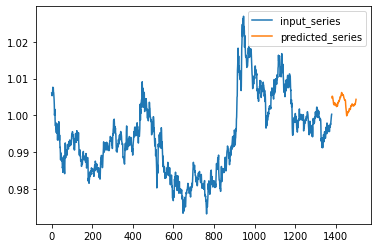

In [20]:
plot_predicted_series(x_test_close[0,:], predicted[0,:])

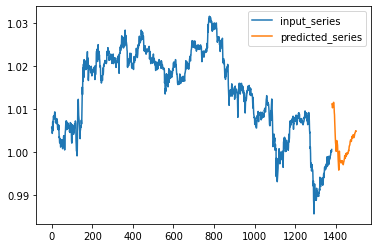

In [21]:
plot_predicted_series(x_test_close[1,:], predicted[1,:])

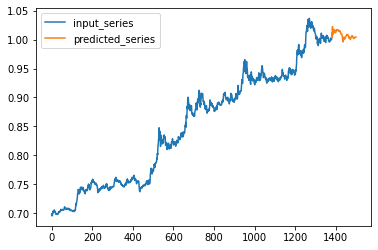

In [22]:
plot_predicted_series(x_test_close[2,:], predicted[2,:])

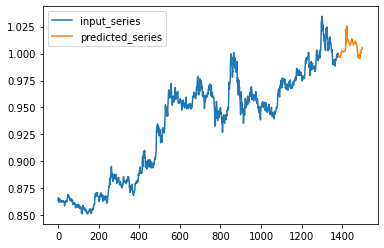

In [23]:
plot_predicted_series(x_test_close[3,:], predicted[3,:])

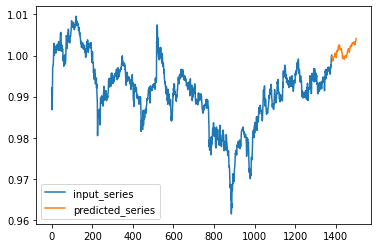

In [24]:
plot_predicted_series(x_test_close[4,:], predicted[4,:])

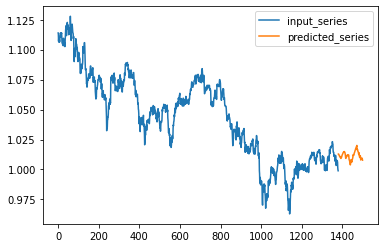

In [25]:
plot_predicted_series(x_test_close[5,:], predicted[5,:])

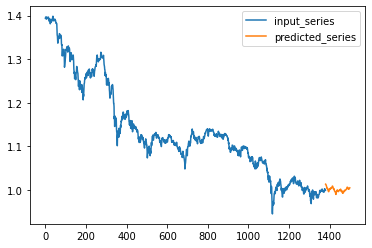

In [26]:
plot_predicted_series(x_test_close[100,:], predicted[100,:])

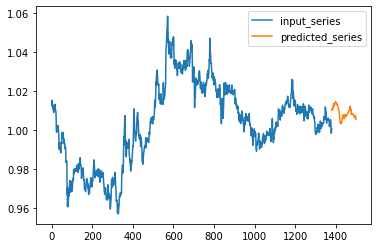

In [27]:
plot_predicted_series(x_test_close[200,:], predicted[200,:])

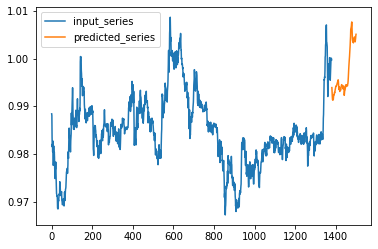

In [28]:
plot_predicted_series(x_test_close[500,:], predicted[500,:])

# Plot predictions for train for comparison

In [29]:
X.shape

(9717840, 60, 10)

In [35]:
predicted_train = best_gru.predict(X[:2400, :,:])


In [38]:
predicted_train = predicted_train.reshape((-1,120)) 

predicted_train.shape

(20, 120)

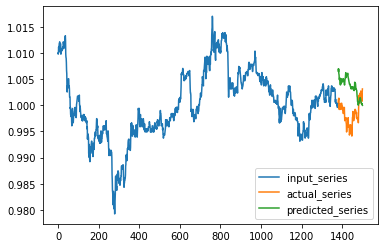

In [39]:
plot_series(x_train_close[0,:], y_train_close[0,:], predicted_train[0,:])

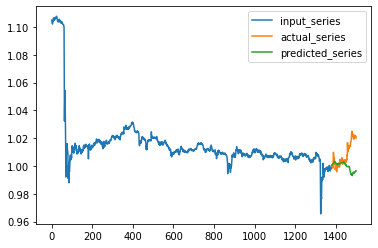

In [40]:
plot_series(x_train_close[1,:], y_train_close[1,:], predicted_train[1,:])

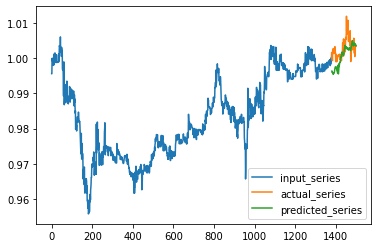

In [41]:
plot_series(x_train_close[2,:], y_train_close[2,:], predicted_train[2,:])

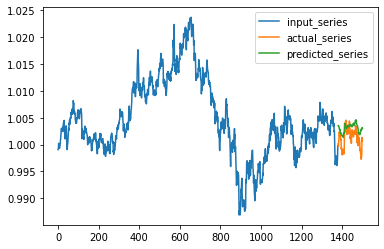

In [42]:
plot_series(x_train_close[3,:], y_train_close[3,:], predicted_train[3,:])

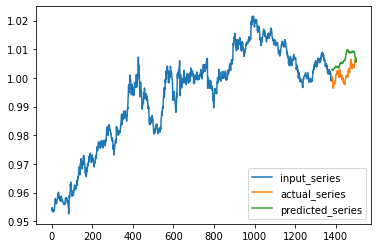

In [43]:
plot_series(x_train_close[4,:], y_train_close[4,:], predicted_train[4,:])

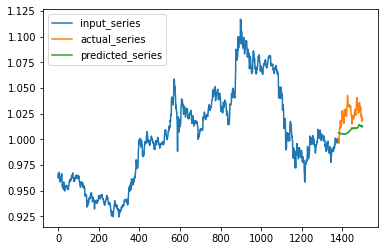

In [44]:
plot_series(x_train_close[5,:], y_train_close[5,:], predicted_train[5,:])

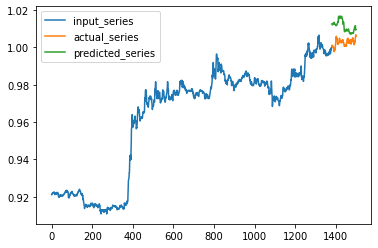

In [45]:
plot_series(x_train_close[6,:], y_train_close[6,:], predicted_train[6,:])

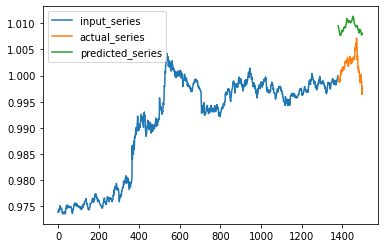

In [46]:
plot_series(x_train_close[7,:], y_train_close[7,:], predicted_train[7,:])

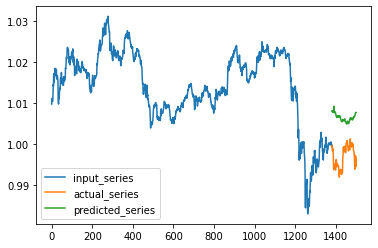

In [47]:
plot_series(x_train_close[8,:], y_train_close[8,:], predicted_train[8,:])

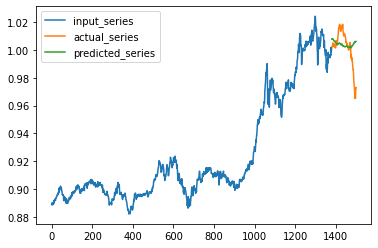

In [48]:
plot_series(x_train_close[9,:], y_train_close[9,:], predicted_train[9,:])

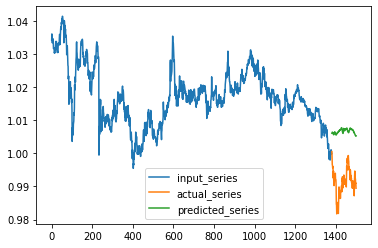

In [49]:
plot_series(x_train_close[10,:], y_train_close[10,:], predicted_train[10,:])